In [1]:
import csv
import sys
import math
import os
import numpy as np
from numpy import asarray
import pandas as pd
from sklearn import linear_model
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import peakutils
from peakutils.plot import plot as pplots
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import mpld3
mpld3.enable_notebook()


In [2]:
def get_data_1(p1,p2):
    
    X = pd.read_csv(p1,sep = ',',header = None, names = ['maxRT_t','maxRT_ab','x_start_t','x_start_ab','diff_start','x_end_t','x_end_ab','diff_end'])
    y_data = pd.read_csv(p2,sep = ',',header = None, names = ['yleft_t','yleft_ab','yright_t','yright_ab'])
    
    y_left = y_data[['yleft_t','yleft_ab']]
    y_right = y_data[['yright_t','yright_ab']]
    
    X = np.array(X)
    y_left= np.array(y_left)
    y_right= np.array(y_right)

    
    return X,y_left,y_right

In [3]:
def get_data_2(p3):
    area_data = np.array(pd.read_csv(p3,sep = ',',header = None).dropna(axis='columns'))
    time = area_data[0]
    time = np.round(time,decimals = 2)
    abundance = area_data[1:]
    
    return time,abundance

In [4]:
def baseline_als(arr):
    temp = [[] for i in range(arr.shape[0])]
    for i in range(arr.shape[0]):
        x = peakutils.baseline(arr[i])
        for j in range(arr.shape[1]):
            temp[i].append(x[j])
    temp = np.array(temp)
    return temp

In [5]:
def predict_data(X_train,y_train,X_test):
    max_depth = 50

    regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                               max_depth=max_depth,
                                                               random_state=None))
    regr_multirf.fit(X_train,y_train)
    predicted_value = regr_multirf.predict(X_test)
    
    return predicted_value

In [6]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    
    return array[idx]

In [7]:
def refine_data(arr1,arr2,arr3):
    refined_data = []
    for i in range(arr2.shape[0]):
        rt = find_nearest(arr1,arr3[i][0])
        refined_data.append([rt,arr2[i][arr1.tolist().index(rt)]])
        
    refined_data = np.array(refined_data)
    
    return refined_data

In [8]:
def getmetrics(arr1,arr2):
    r2 = r2_score(arr1,arr2)
    rsme = mean_squared_error(arr1,arr2)
    return r2,rsme
    

In [9]:
def main():
    path1 = '/home/geraldfj/Documents/python/LR_ML1/X_C29_data'
    path2 = '/home/geraldfj/Documents/python/LR_ML1/y_C29_data'
    path3 = '/home/geraldfj/Documents/python/LR_ML1/area_data'
    
    
    
    X,yleft,yright = get_data_1(path1,path2)
    time,abundance = get_data_2(path3)
    baseline = baseline_als(abundance)
    
    X.shape,yleft.shape,yright.shape
    
    X,yleft,yright,abundance = shuffle(X,yleft,yright,abundance)
    
    Xtrain,Xtest,yleft_train,yleft_test,yright_train,yright_test,ab_train,ab_test,bb_train,bb_test = train_test_split(X,yleft,yright,abundance,baseline,test_size=0.1,random_state=40)
    
    
    yleft_predicted = predict_data(Xtrain,yleft_train,Xtest)
    yright_predicted = predict_data(Xtrain,yright_train,Xtest)
    
    yleft_refined = refine_data(time,ab_test,yleft_predicted)
    yright_refined = refine_data(time,ab_test,yright_predicted)
    
    r2left,rsmeleft = getmetrics(yleft_test,yleft_refined)
    r2right,rsmeright = getmetrics(yright_test,yright_refined)
    
    
    #Printing output for certain rows
    dd = 1 #which dataset to show
    
    print("actual_left = ",yleft_test[dd])
    print("predicted_left_raw = ",yleft_predicted[dd])
    print("predicted_left_refined = ",yleft_refined[dd])
    print("actual_right = ",yright_test[dd])
    print("predicted_right_raw = ",yright_predicted[dd])
    print("predicted_right_refined = ",yright_refined[dd])
    print("r2_square_left,rsme_left = ",r2left,rsmeleft)
    print("r2_square_right,rsme_right = ",r2right,rsmeright)
    
    
    
    plt.plot(time,ab_test[dd])
    
    plt.plot([yleft_refined[dd][0],yleft_refined[dd][0]],
             [bb_test[dd][time.tolist().index(yleft_refined[dd][0])]
              ,yleft_refined[dd][1]],
             linestyle = '-',linewidth = 0.5,color = 'r')
    
    plt.plot([yright_refined[dd][0],yright_refined[dd][0]],
             [bb_test[dd][time.tolist().index(yright_refined[dd][0])]
              ,yright_refined[dd][1]],
             linestyle = '-',linewidth = 0.5,color = 'r')
    
    plt.plot([yleft_refined[dd][0],yright_refined[dd][0]],
            [bb_test[dd][time.tolist().index(yleft_refined[dd][0])],
            bb_test[dd][time.tolist().index(yright_refined[dd][0])]],
            linestyle = '-',linewidth = 0.5,color = 'r')

actual_left =  [4.11230000e+01 1.39855802e+05]
predicted_left_raw =  [4.1122400e+01 1.3746423e+05]
predicted_left_refined =  [4.11200000e+01 1.38970049e+05]
actual_right =  [4.12230000e+01 1.75325043e+05]
predicted_right_raw =  [4.12228500e+01 1.75011253e+05]
predicted_right_refined =  [4.1220000e+01 1.8010166e+05]
r2_square_left,rsme_left =  0.49930475584120193 767996.9064137642
r2_square_right,rsme_right =  -0.0015441807199579882 3517542.9066353296


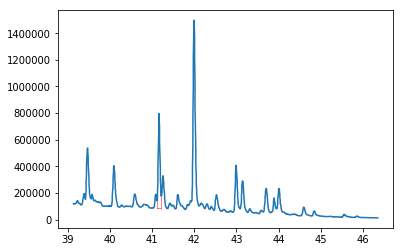

In [10]:
if __name__ == "__main__":
    main()